<a href="https://colab.research.google.com/github/aayisha-muhammed/Ayisha/blob/main/rainpredictionnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
# Instead of importing plot_confusion_matrix and plot_roc_curve directly,
# import ConfusionMatrixDisplay and RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [5]:
# Load dataset
file_path = '/content/weatherAUS.csv'
df = pd.read_csv(file_path)

# Inspect the dataset
df.head()



,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [10]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Drop rows where target 'RainTomorrow' is missing
df = df.dropna(subset=['RainTomorrow'])

# Impute missing values for other features (for numeric and categorical separately)
from sklearn.impute import SimpleImputer

# Impute numeric columns
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='mean')

# Use .loc to avoid SettingWithCopyWarning
df.loc[:, numeric_features] = imputer_num.fit_transform(df[numeric_features])

# Impute categorical columns
categorical_features = df.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')

# Use .loc to avoid SettingWithCopyWarning
df.loc[:, categorical_features] = imputer_cat.fit_transform(df[categorical_features])


Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


In [12]:
df.shape[0]

142193

In [13]:
from sklearn.preprocessing import LabelEncoder

# Encoding categorical variables
le = LabelEncoder()
df['RainTomorrow'] = le.fit_transform(df['RainTomorrow'])
df['RainToday'] = le.fit_transform(df['RainToday'])

for col in categorical_features:
    df[col] = le.fit_transform(df[col])


In [14]:
from sklearn.preprocessing import StandardScaler

# Scale numeric features
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])


In [15]:
# prompt: check outlier

# Identify outliers using IQR for numeric features
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

for feature in numeric_features:
    outliers = detect_outliers_iqr(df[feature])
    if outliers.any():
        print(f"Outliers detected in {feature}:")
        print(df[outliers][feature])
        # You can handle outliers here (e.g., remove them, cap them, etc.)
        # Example: Remove outliers
        # df = df[~outliers]


# You can also visualize outliers using box plots:
# for feature in numeric_features:
#     plt.figure(figsize=(8, 6))
#     sns.boxplot(x=df[feature])
#     plt.title(f'Box Plot of {feature}')
#     plt.show()

Outliers detected in MinTemp:
46848    -2.987431
46849    -2.924822
46909    -2.893518
46922    -2.893518
46923    -3.159604
            ...   
105599    3.007340
107341    3.007340
108016    3.069949
116368    2.976036
144189    2.944732
Name: MinTemp, Length: 62, dtype: float64
Outliers detected in MaxTemp:
68        3.034408
2904      2.879686
4457      3.175065
5885      3.076605
5890      2.978146
            ...   
144530    2.893752
144535    2.921883
144572    2.879686
144858    2.879686
144891    2.935949
Name: MaxTemp, Length: 459, dtype: float64
Outliers detected in Rainfall:
11       -0.017805
12        1.573042
13        0.148403
15        0.000000
17        1.715506
            ...   
145336    0.000000
145391    0.528307
145392    1.216882
145393    3.828720
145394    0.172147
Name: Rainfall, Length: 27658, dtype: float64
Outliers detected in Evaporation:
6049      2.061226
6050      2.945035
6051      2.250614
6052      1.682450
6053      1.871838
            ...   
143

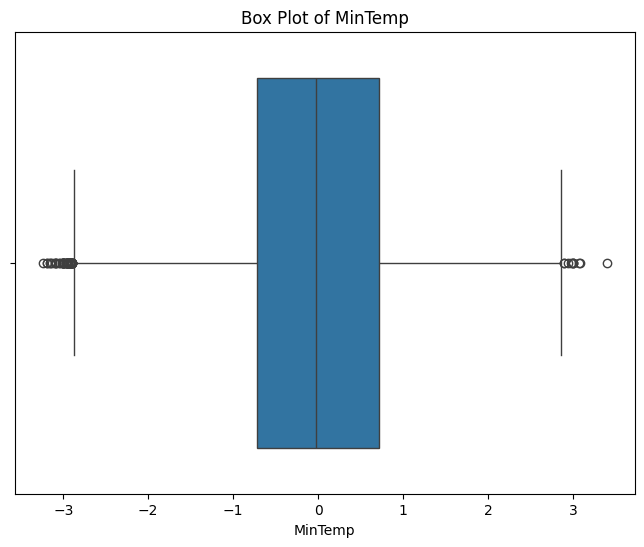

Outliers detected in MinTemp:
46848    -2.987431
46849    -2.924822
46909    -2.893518
46922    -2.893518
46923    -3.159604
            ...   
105599    3.007340
107341    3.007340
108016    3.069949
116368    2.976036
144189    2.944732
Name: MinTemp, Length: 62, dtype: float64


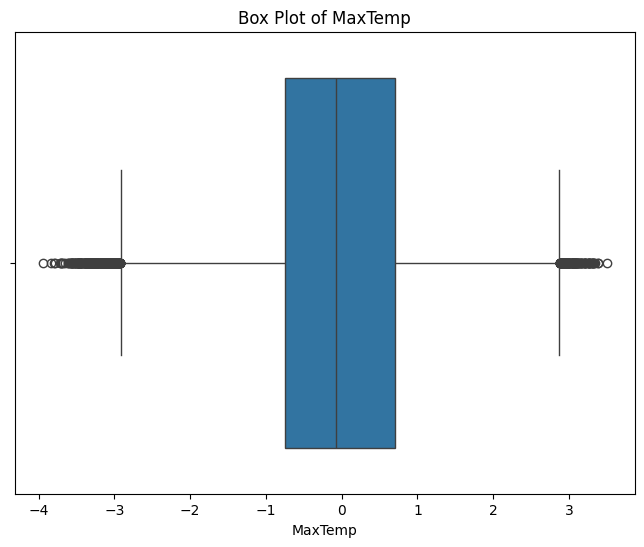

Outliers detected in MaxTemp:
68        3.034408
2904      2.879686
4457      3.175065
5885      3.076605
5890      2.978146
            ...   
144530    2.893752
144535    2.921883
144572    2.879686
144858    2.879686
144891    2.935949
Name: MaxTemp, Length: 459, dtype: float64


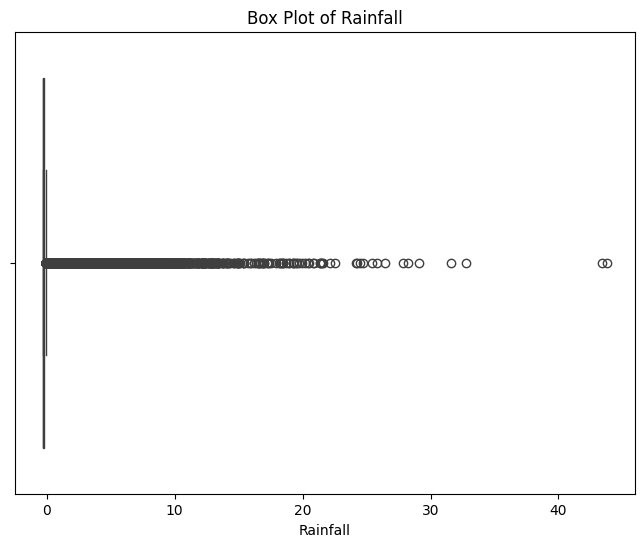

Outliers detected in Rainfall:
11       -0.017805
12        1.573042
13        0.148403
15        0.000000
17        1.715506
            ...   
145336    0.000000
145391    0.528307
145392    1.216882
145393    3.828720
145394    0.172147
Name: Rainfall, Length: 27658, dtype: float64


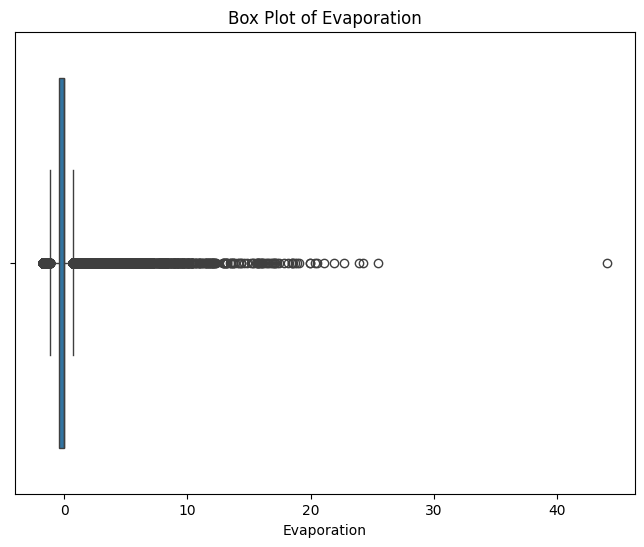

Outliers detected in Evaporation:
6049      2.061226
6050      2.945035
6051      2.250614
6052      1.682450
6053      1.871838
            ...   
143864    0.798641
143865    0.735511
143870    0.798641
143872    0.798641
143876    1.303675
Name: Evaporation, Length: 29185, dtype: float64


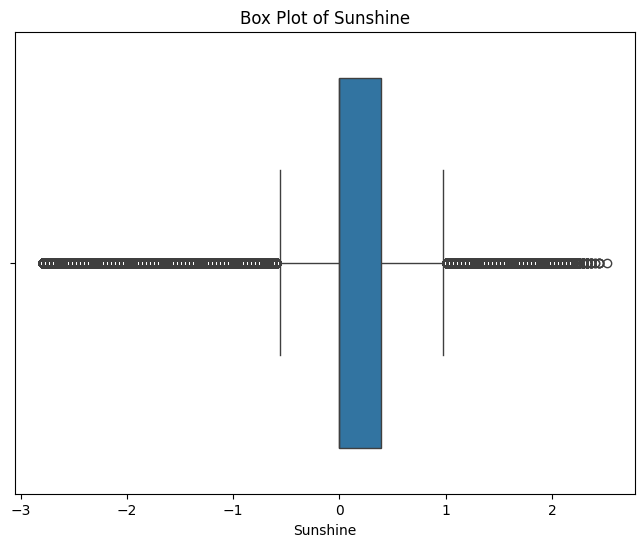

Outliers detected in Sunshine:
6049      1.709429
6050      1.965378
6051      2.075070
6052      1.087838
6053      1.672865
            ...   
142297    1.197530
142298    1.234094
142300    1.234094
142301    1.087838
142302    1.124402
Name: Sunshine, Length: 45264, dtype: float64


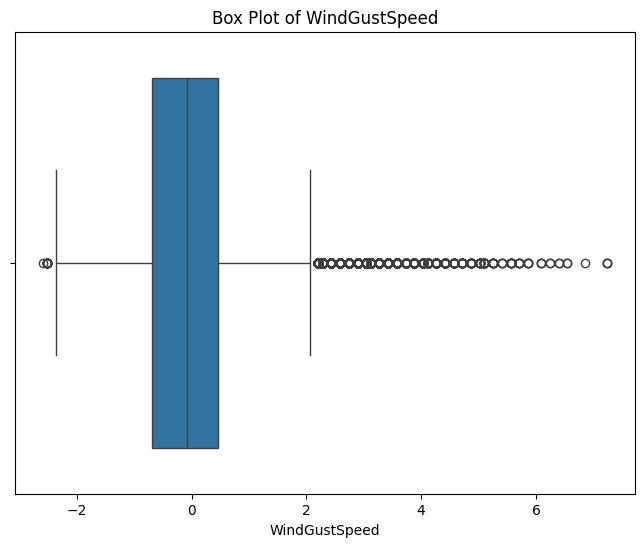

Outliers detected in WindGustSpeed:
8         3.045721
52        4.415757
62        3.274060
84        2.284589
103       2.208476
            ...   
145256    2.208476
145257    2.208476
145278    2.436816
145320    2.893494
145321    2.436816
Name: WindGustSpeed, Length: 5386, dtype: float64


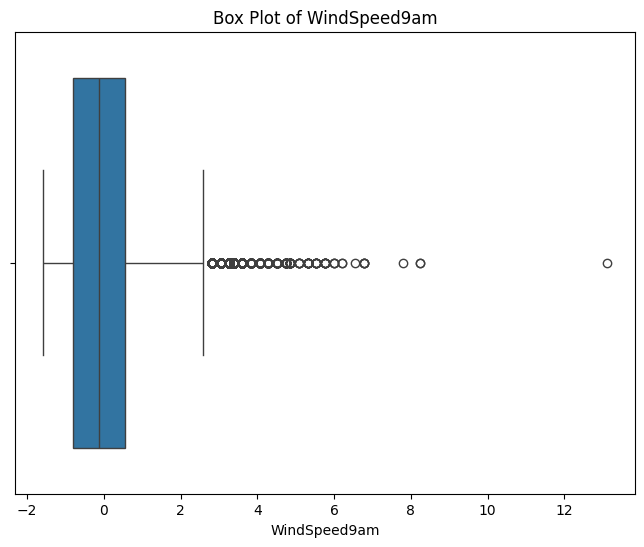

Outliers detected in WindSpeed9am:
3308      3.841127
3693      2.824299
5050      3.389204
9104      2.824299
9198      3.050261
            ...   
141189    2.824299
141403    2.824299
141419    2.824299
141755    2.824299
144130    3.050261
Name: WindSpeed9am, Length: 1739, dtype: float64


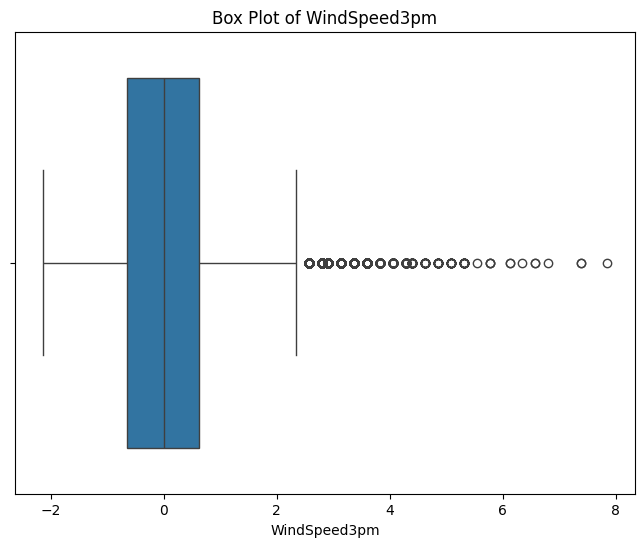

Outliers detected in WindSpeed3pm:
52        3.366663
356       3.137346
381       3.595981
1626      2.908028
1692      3.137346
            ...   
144095    2.793369
145108    2.564051
145189    3.366663
145193    2.564051
145278    2.793369
Name: WindSpeed3pm, Length: 2458, dtype: float64


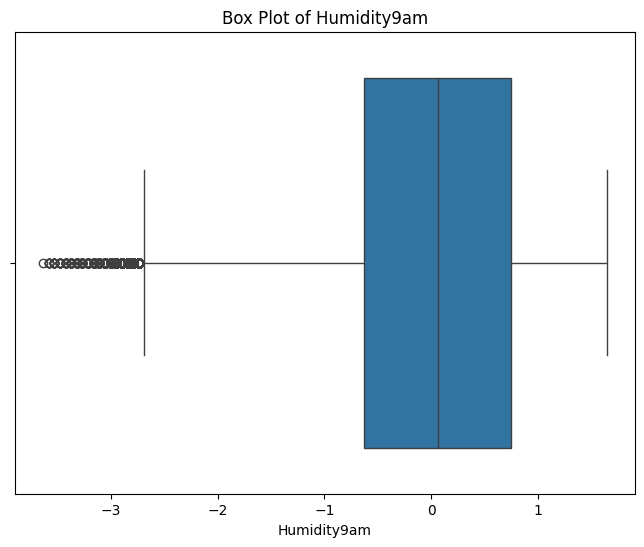

Outliers detected in Humidity9am:
6304     -2.738421
6306     -2.738421
6321     -2.844062
6322     -3.160986
6341     -2.844062
            ...   
145263   -2.791241
145264   -2.949703
145265   -2.738421
145342   -2.844062
145353   -2.738421
Name: Humidity9am, Length: 1419, dtype: float64


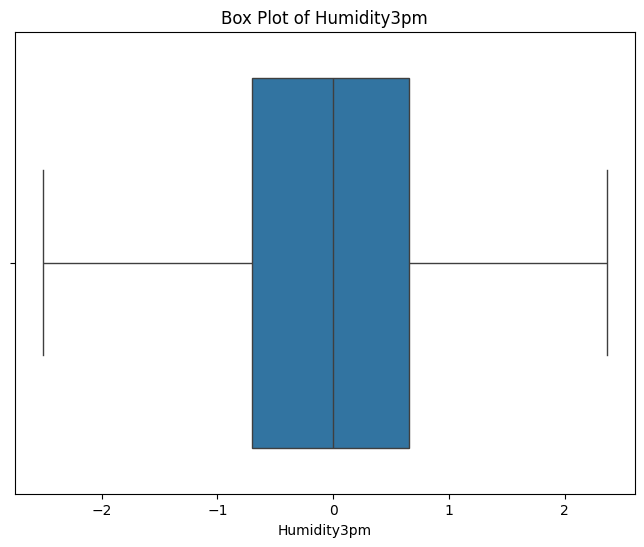

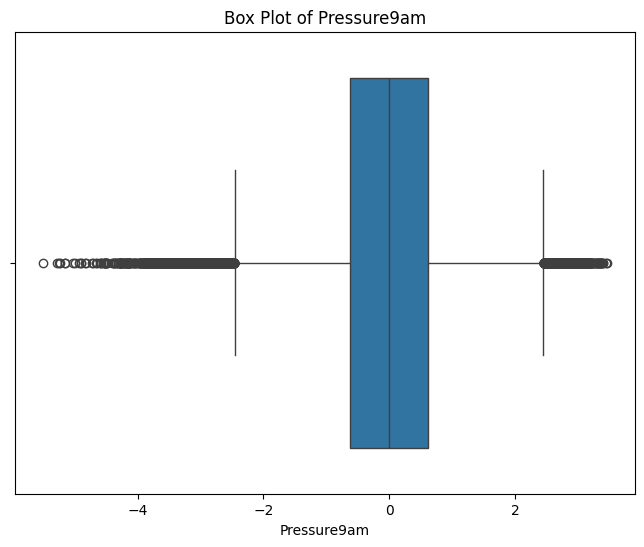

Outliers detected in Pressure9am:
12       -3.461752
296      -2.942944
317      -2.542720
363      -2.542720
466       2.763952
            ...   
143707   -2.587189
144561   -2.735420
145278   -3.417283
145279   -2.942944
145280   -2.616835
Name: Pressure9am, Length: 2708, dtype: float64


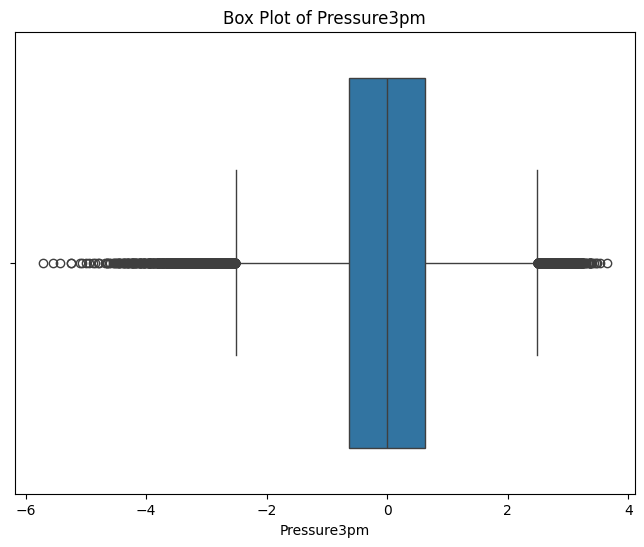

Outliers detected in Pressure3pm:
12       -3.331187
52       -2.612814
271      -2.747508
316      -2.642746
466       2.745053
            ...   
144220   -2.597847
144528   -2.537983
144561   -2.672678
145278   -3.899899
145279   -3.001932
Name: Pressure3pm, Length: 2367, dtype: float64


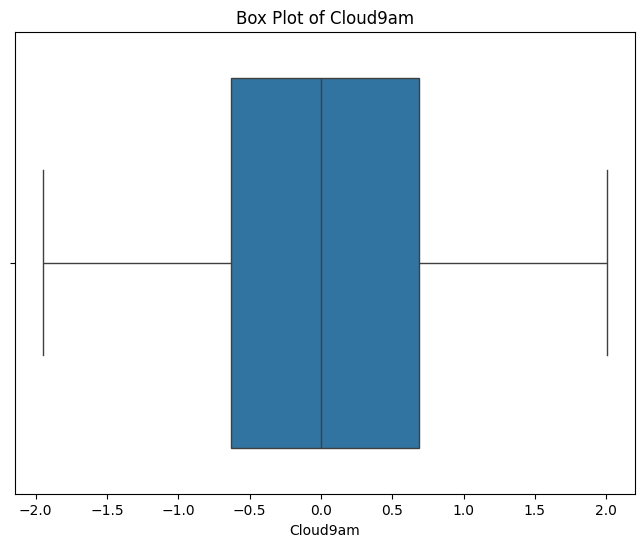

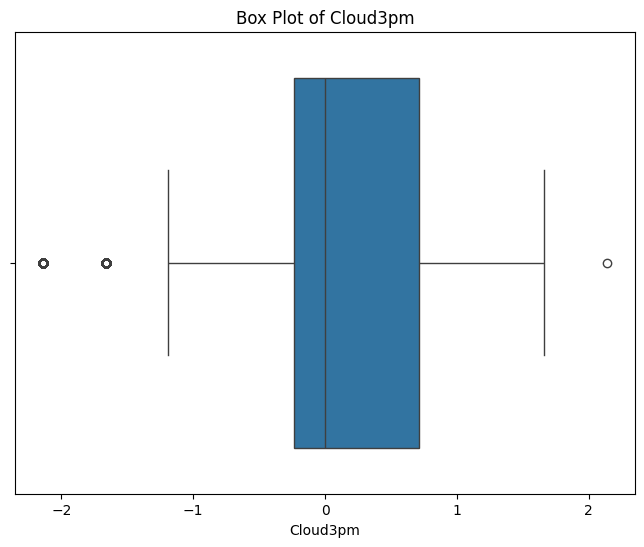

Outliers detected in Cloud3pm:
16       -1.664449
17       -1.664449
21       -1.664449
25       -1.664449
26       -1.664449
            ...   
145381   -1.664449
145387   -1.664449
145389   -1.664449
145416   -1.664449
145428   -1.664449
Name: Cloud3pm, Length: 19785, dtype: float64


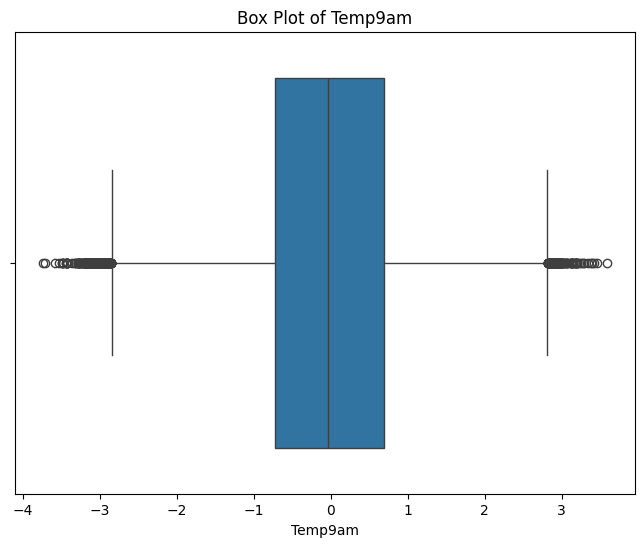

Outliers detected in Temp9am:
5890      3.184801
6085      2.875785
6372      3.138449
6804      2.891236
7466      3.200252
            ...   
144188    2.937588
144504    2.875785
144572    2.999392
144881    2.860334
144891    2.953039
Name: Temp9am, Length: 303, dtype: float64


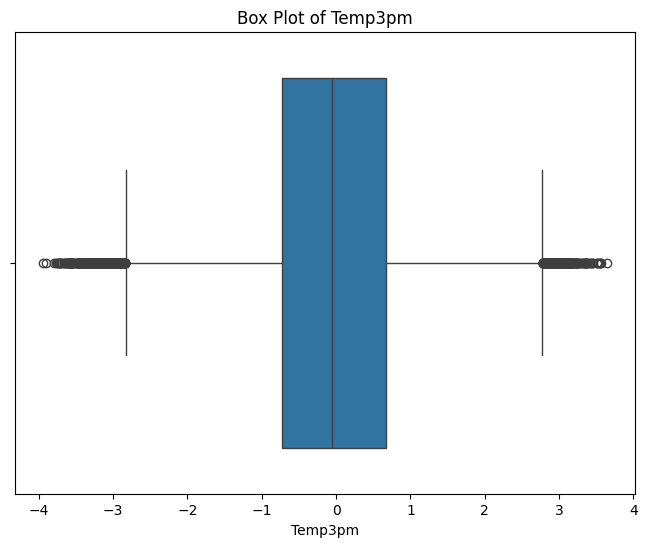

Outliers detected in Temp3pm:
44        2.883641
60        2.839977
61        2.956413
62        2.941859
67        2.898195
            ...   
144891    2.883641
144961    2.810868
145253    2.825423
145265    2.825423
145357    2.781760
Name: Temp3pm, Length: 840, dtype: float64


In [16]:
# prompt: give outlier shown in boxplot

# Visualize outliers using box plots and identify them
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

    # Calculate the IQR and identify outliers
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]

    if not outliers.empty:
        print(f"Outliers detected in {feature}:")
        print(outliers)

#outlier

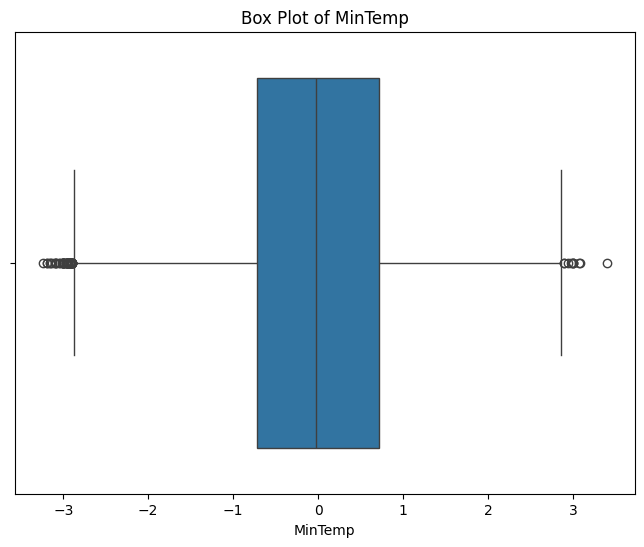

Outliers detected in MinTemp:
Removed 62 outliers from MinTemp


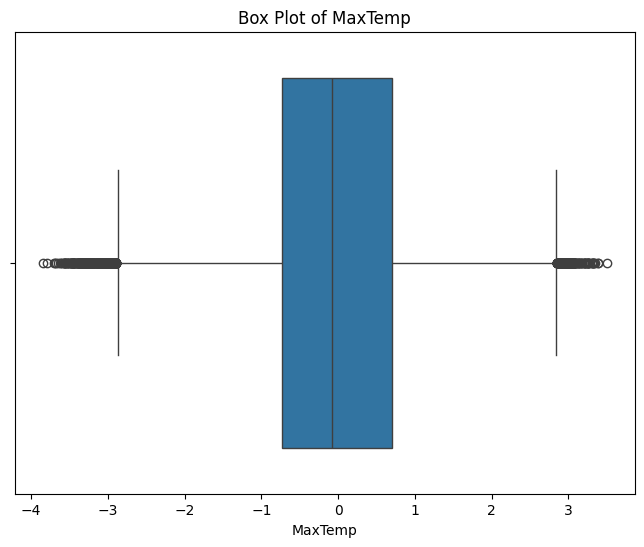

Outliers detected in MaxTemp:
Removed 498 outliers from MaxTemp


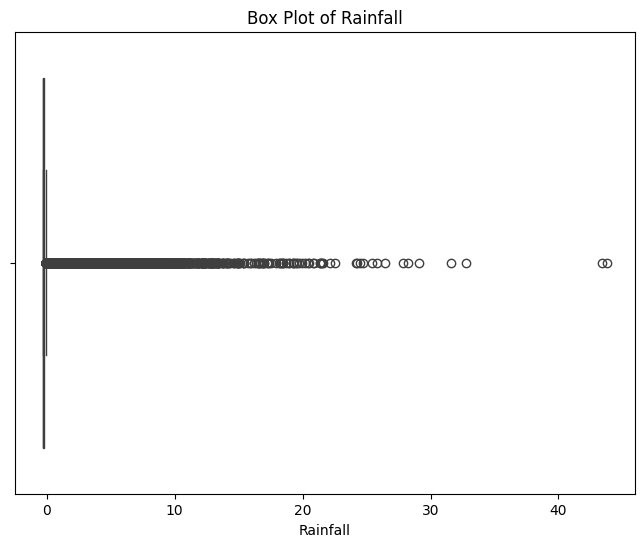

Outliers detected in Rainfall:
Removed 27472 outliers from Rainfall


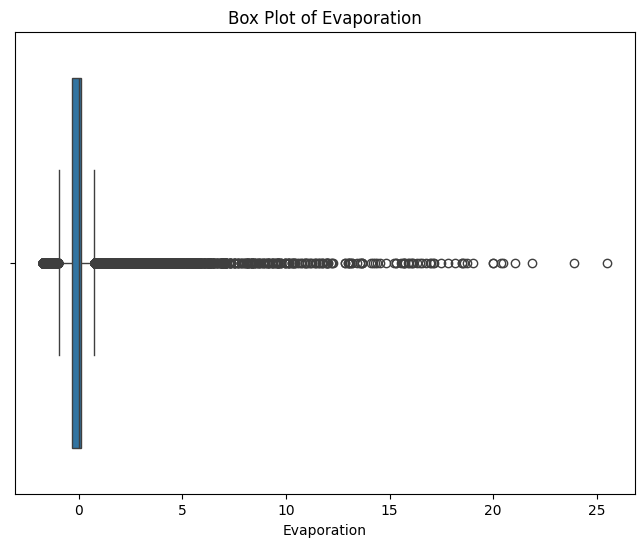

Outliers detected in Evaporation:
Removed 27606 outliers from Evaporation


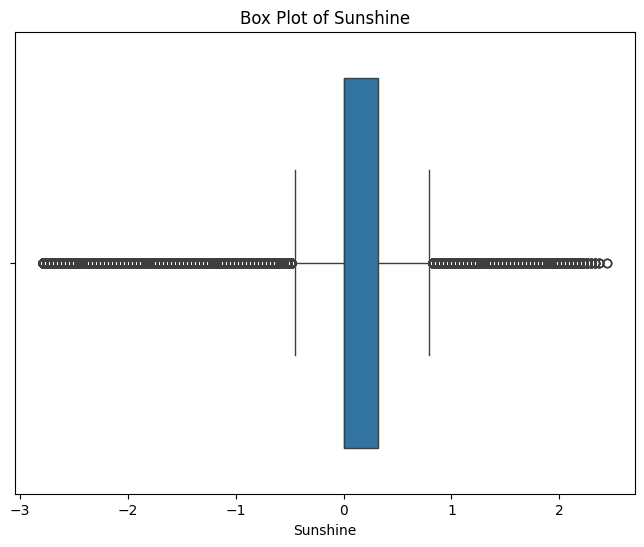

Outliers detected in Sunshine:
Removed 24875 outliers from Sunshine


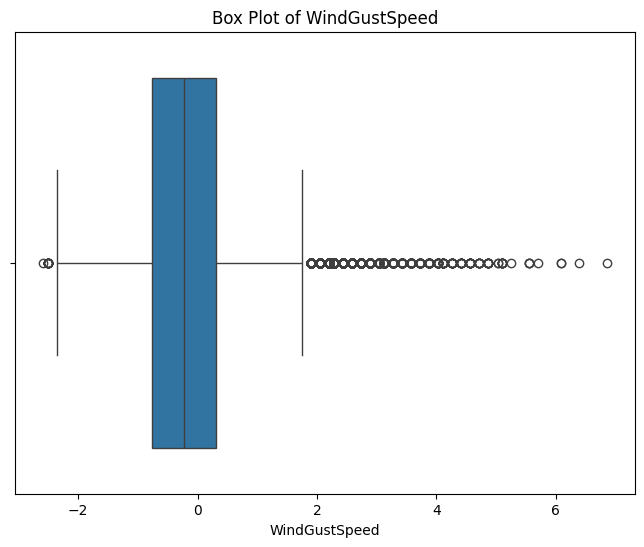

Outliers detected in WindGustSpeed:
Removed 2469 outliers from WindGustSpeed


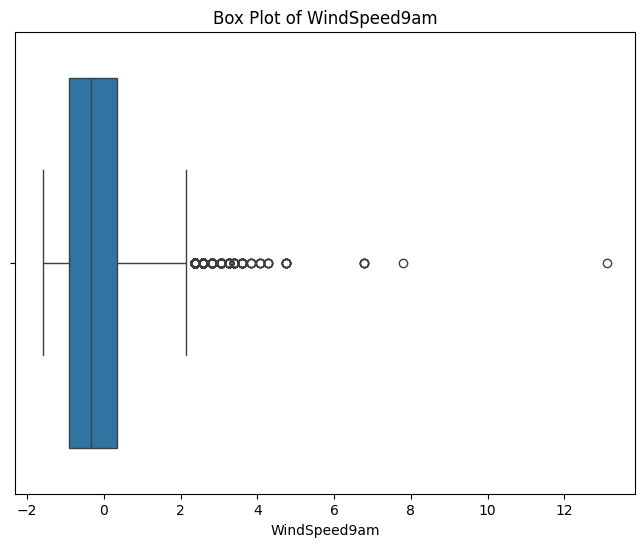

Outliers detected in WindSpeed9am:
Removed 530 outliers from WindSpeed9am


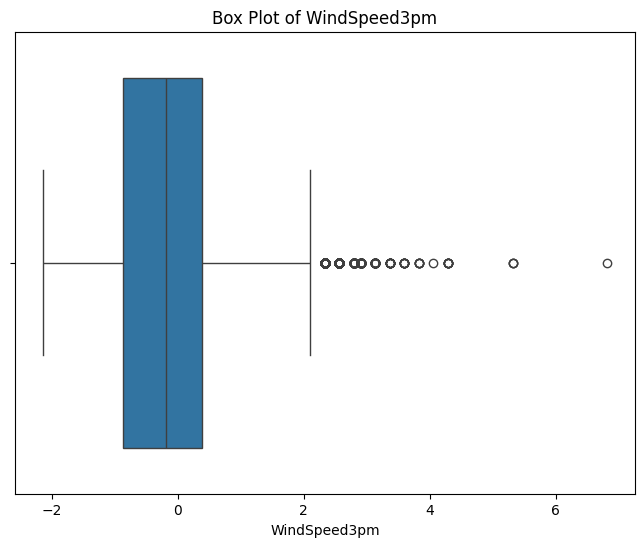

Outliers detected in WindSpeed3pm:
Removed 635 outliers from WindSpeed3pm


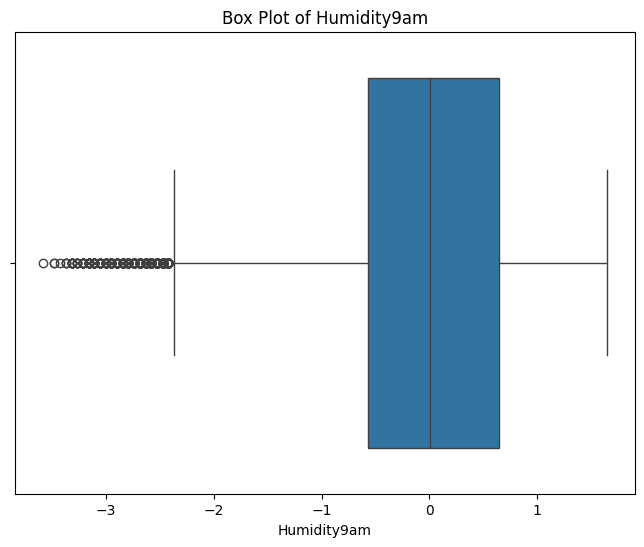

Outliers detected in Humidity9am:
Removed 740 outliers from Humidity9am


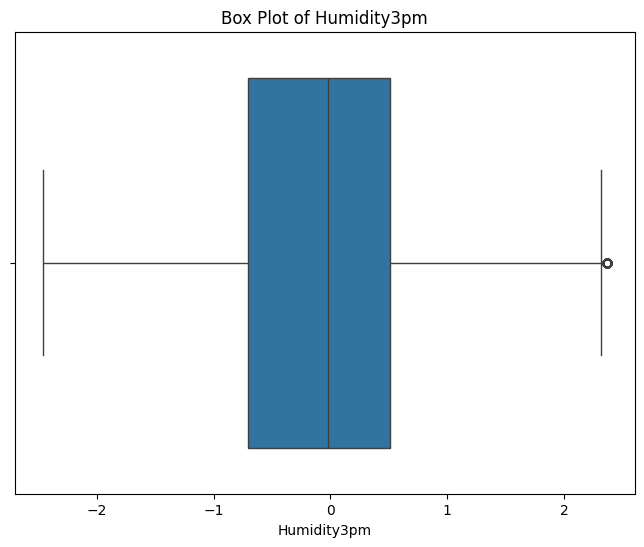

Outliers detected in Humidity3pm:
Removed 94 outliers from Humidity3pm


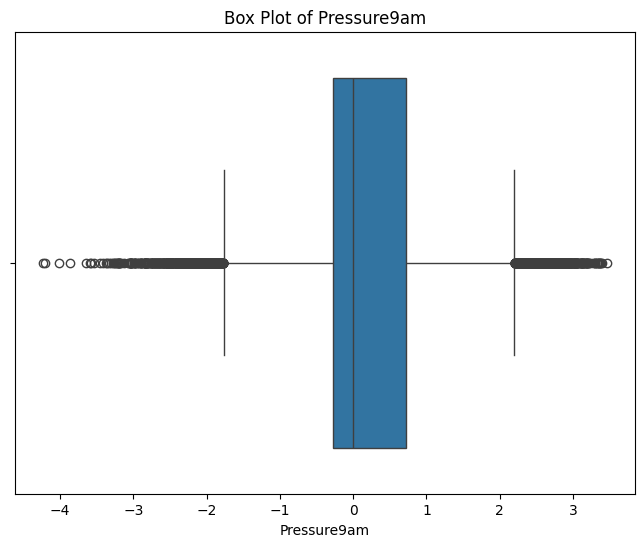

Outliers detected in Pressure9am:
Removed 1976 outliers from Pressure9am


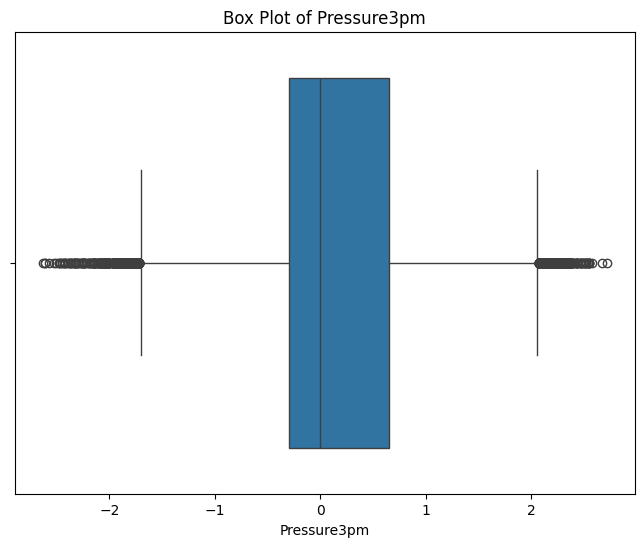

Outliers detected in Pressure3pm:
Removed 869 outliers from Pressure3pm


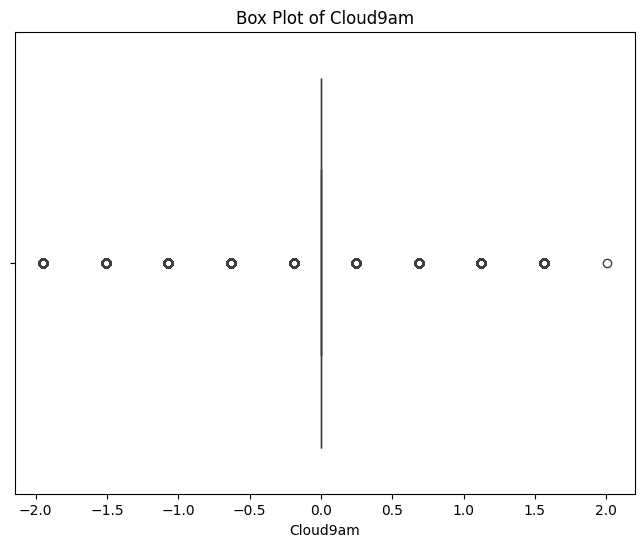

Outliers detected in Cloud9am:
Removed 21498 outliers from Cloud9am


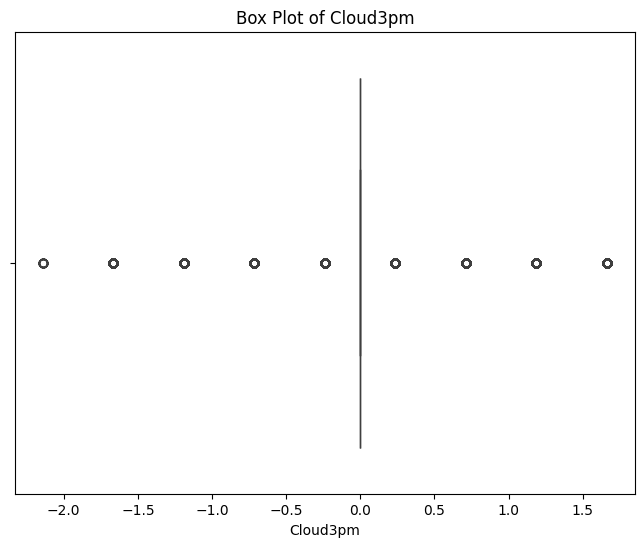

Outliers detected in Cloud3pm:
Removed 2481 outliers from Cloud3pm


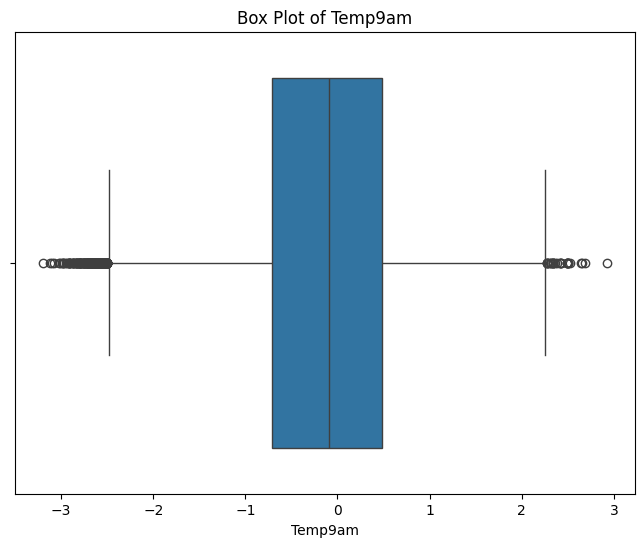

Outliers detected in Temp9am:
Removed 248 outliers from Temp9am


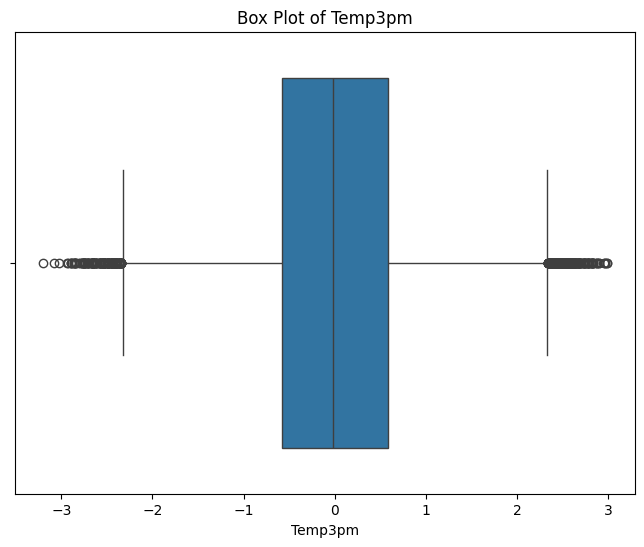

Outliers detected in Temp3pm:
Removed 399 outliers from Temp3pm


In [17]:
# prompt: remove the outlier withboxplot

# ... (Your existing code)

# Visualize outliers using box plots and remove them
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

    # Calculate the IQR and identify outliers
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index

    if not outliers.empty:
        print(f"Outliers detected in {feature}:")
        # Remove outliers
        df.drop(outliers, inplace=True)
        print(f"Removed {len(outliers)} outliers from {feature}")

# ... (Rest of your code)

In [18]:
df.shape[0]

29741

In [25]:
import os

# Create the directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Save the heatmap after creating the directory
plt.savefig('images/corr_heatmap.png', facecolor='white', dpi=100)


<Figure size 640x480 with 0 Axes>

In [26]:
# Save the heatmap in the current directory
plt.savefig('corr_heatmap.png', facecolor='white', dpi=100)


<Figure size 640x480 with 0 Axes>

In [27]:
print(df[['Cloud9am', 'Cloud3pm']].isnull().sum())


Cloud9am    0
Cloud3pm    0
dtype: int64


In [28]:
# Impute Cloud9am and Cloud3pm if needed
df['Cloud9am'].fillna(df['Cloud9am'].mean(), inplace=True)
df['Cloud3pm'].fillna(df['Cloud3pm'].mean(), inplace=True)


<ipython-input-28-381e55fff946>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cloud9am'].fillna(df['Cloud9am'].mean(), inplace=True)
<ipython-input-28-381e55fff946>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

#Correlation Matrix


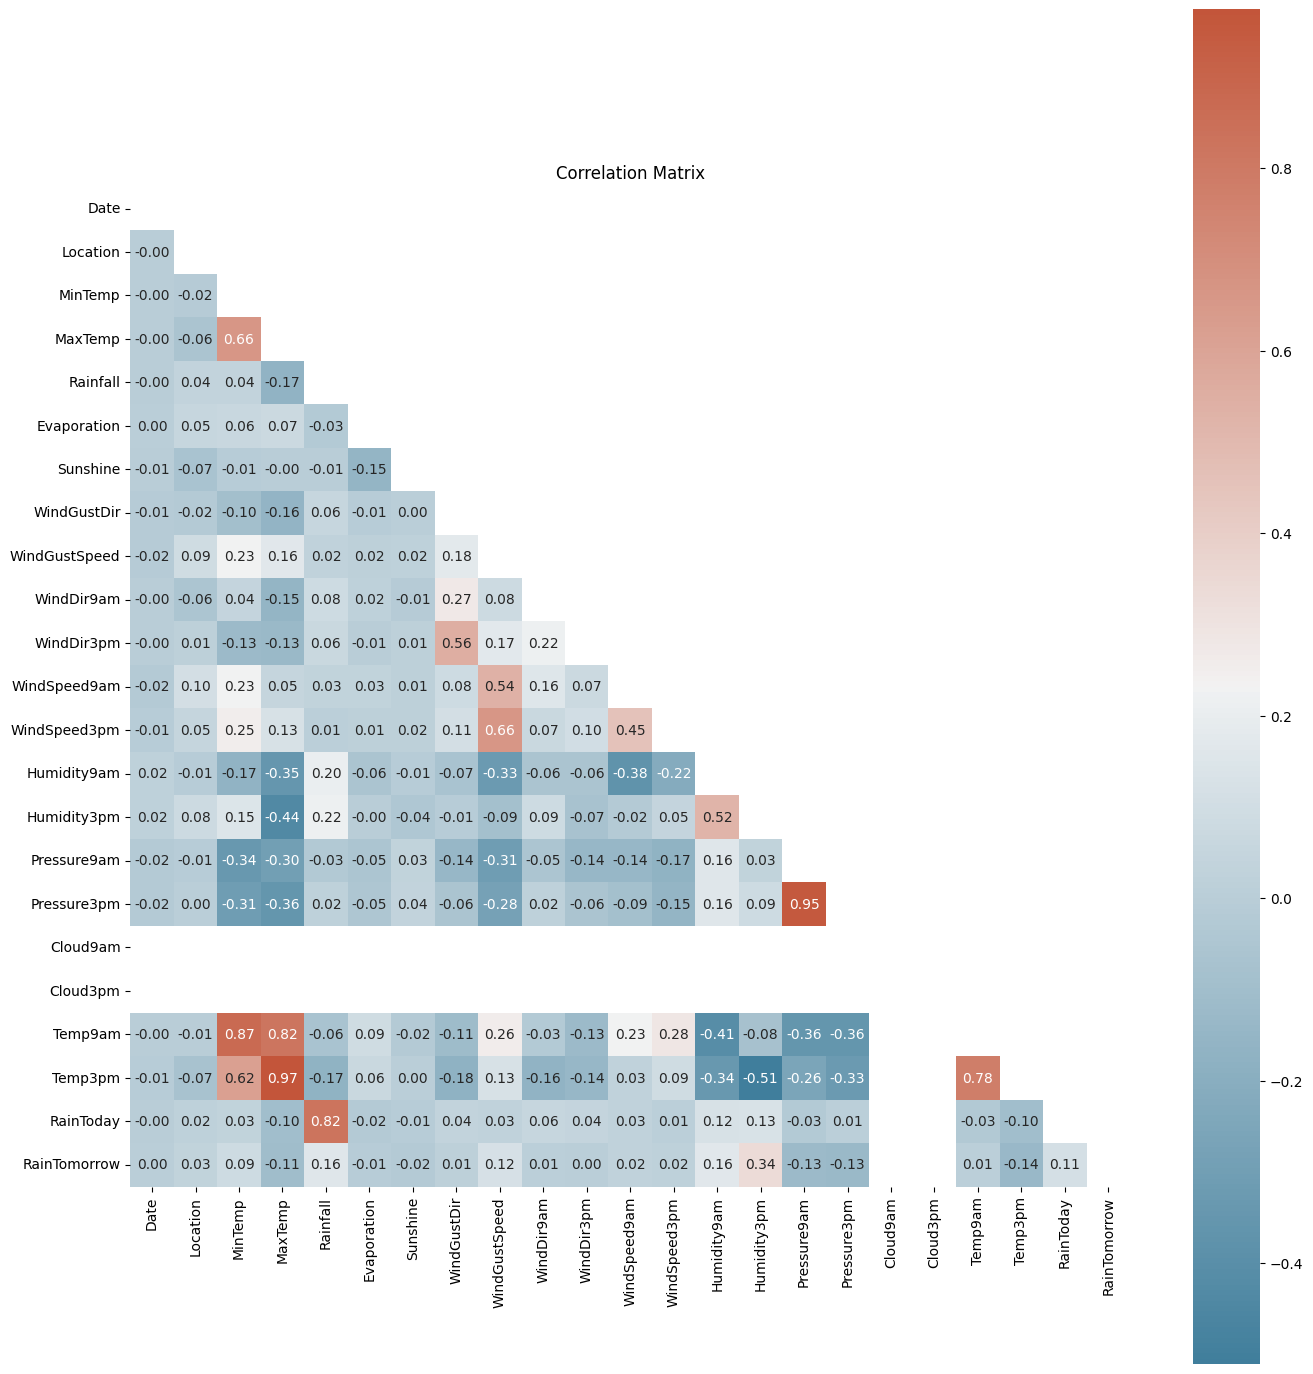

In [29]:
plt.figure(figsize=(14, 14)) # Now plt is defined and can be used
plt.title('Correlation Matrix')
# Creating a mask to block the top right half of the heatmap (redundant information)
mask = np.triu(np.ones_like(df.corr()))
# Custom color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.2f', square=True, cmap=cmap)
plt.tight_layout()
plt.savefig('images/corr_heatmap.png', facecolor='white', dpi=100);


<ipython-input-32-f371b4b558f7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RainToday',


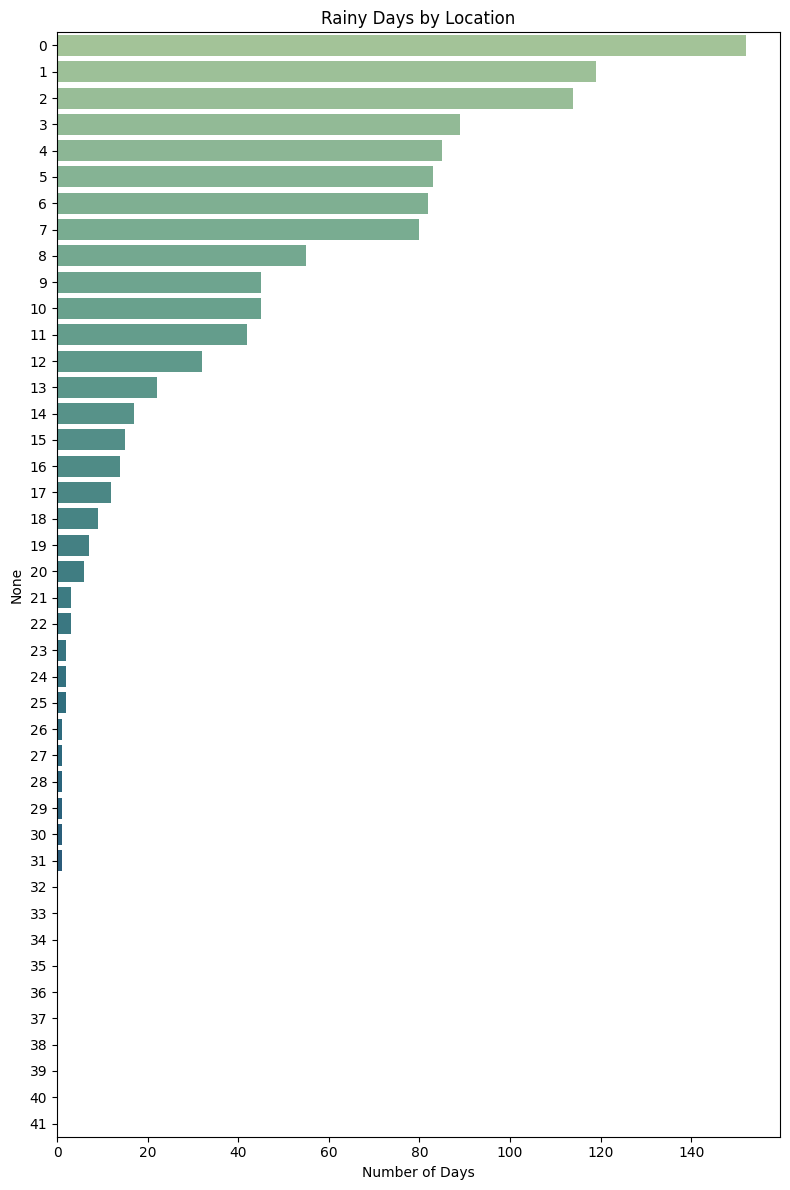

In [32]:



# Assuming 'df' is your main DataFrame containing weather data

# Create df_rain_by_loc by grouping by location and summing 'RainToday'
df_rain_by_loc = df.groupby('Location')['RainToday'].sum().reset_index()

plt.figure(figsize=(8, 12))
sns.barplot(x='RainToday',
            y=df_rain_by_loc.index,  # or y='Location' if 'Location' is a column
            data=df_rain_by_loc.sort_values('RainToday', ascending=False),
            orient='h',
            palette='crest'
            )
plt.xlabel('Number of Days')
plt.title('Rainy Days by Location')
plt.tight_layout()
plt.savefig('images/rainy_days_by_loc.png', facecolor='white', dpi=100);

In [37]:
# Convert the Date column to datetime format, and handle errors by coercing invalid dates to NaT (Not a Time)
df_imputed_final['Date'] = pd.to_datetime(df_imputed_final['Date'], errors='coerce')

# Check for any missing or invalid Date entries after conversion
missing_dates = df_imputed_final['Date'].isnull().sum()
print(f"Missing/Invalid Date entries: {missing_dates}")

# Drop rows where Date is missing (optional if Date is crucial)
df_imputed_final = df_imputed_final.dropna(subset=['Date'])

# Extract the Month from the Date column
df_month = df_imputed_final.copy()
df_month.insert(1, 'Month', df_month['Date'].dt.month)

# Drop the original Date column if no longer needed
df_month.drop(columns='Date', inplace=True)

# Check the first few rows of the updated dataframe
df_month.head()


Missing/Invalid Date entries: 0


,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
1,1,2,-0.749174,0.263480,-0.278989,0.0,-6.495101e-16,14,0.305648,6,...,-1.312265,-1.289821,-1.045586,-1.116203,0.0,-4.219974e-16,0.032832,0.380274,0,0
3,1,2,-0.467436,0.671383,-0.278989,0.0,-6.495101e-16,4,-1.216614,9,...,-1.259444,-1.728162,-0.007969,-0.367897,0.0,-4.219974e-16,0.171889,0.700472,0,0
5,1,2,0.377780,0.910498,-0.255245,0.0,-6.495101e-16,14,1.219006,13,...,-0.731238,-1.387230,-1.253110,-1.475389,0.0,-4.219974e-16,0.558160,1.049779,0,0
7,1,2,-0.702218,0.488530,-0.278989,0.0,-6.495101e-16,13,-0.379370,10,...,-1.100982,-1.582048,-0.630539,-0.771982,0.0,-4.219974e-16,-0.106226,0.554927,0,0
9,1,2,0.142998,0.966761,-0.112781,0.0,-6.495101e-16,13,-0.912162,8,...,-0.572776,-1.192413,-1.579218,-1.430491,0.0,-4.219974e-16,0.480906,0.947898,1,0


In [38]:
categoricals = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df_dummies = pd.get_dummies(df_month, columns=categoricals)
df_dummies.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_6,WindDir3pm_7,WindDir3pm_8,WindDir3pm_9,WindDir3pm_10,WindDir3pm_11,WindDir3pm_12,WindDir3pm_13,WindDir3pm_14,WindDir3pm_15
1,-0.749174,0.263480,-0.278989,0.0,-6.495101e-16,0.305648,-1.130034,0.385532,-1.312265,-1.289821,...,False,False,False,False,False,False,False,False,False,True
3,-0.467436,0.671383,-0.278989,0.0,-6.495101e-16,-1.216614,-0.339167,-1.105034,-1.259444,-1.728162,...,False,False,False,False,False,False,False,False,False,False
5,0.377780,0.910498,-0.255245,0.0,-6.495101e-16,1.219006,0.564680,0.614850,-0.731238,-1.387230,...,False,False,False,False,False,False,False,True,False,False
7,-0.702218,0.488530,-0.278989,0.0,-6.495101e-16,-0.379370,-0.904072,-0.187763,-1.100982,-1.582048,...,False,False,False,False,False,False,False,True,False,False
9,0.142998,0.966761,-0.112781,0.0,-6.495101e-16,-0.912162,0.112756,-0.875716,-0.572776,-1.192413,...,False,False,False,False,True,False,False,False,False,False


#Splitting the dataset into training and test sets

In [39]:

df_final = df_dummies.copy()
X = df_final.drop(columns='RainTomorrow')
y = df_final.RainTomorrow
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Train size:', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Train size: 22305
Test size:  7436


#Modeling

#Logistic Regression

In [40]:

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


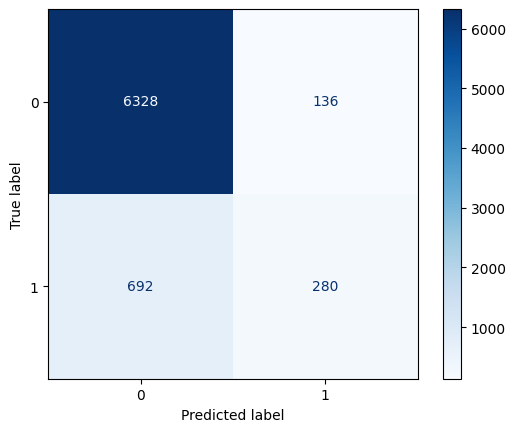



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      6464
           1       0.67      0.29      0.40       972

    accuracy                           0.89      7436
   macro avg       0.79      0.63      0.67      7436
weighted avg       0.87      0.89      0.87      7436



ROC Curve
-----------------------------------------------------


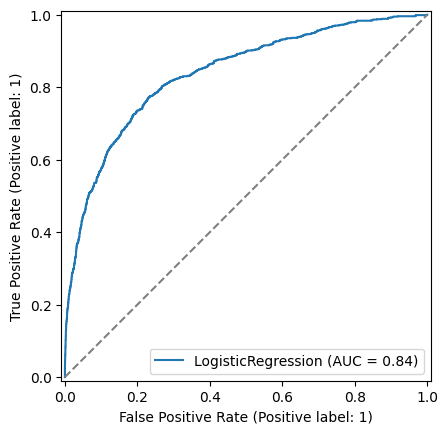



Checking model fitness
-----------------------------------------------------
Train score: 0.8875
Test score:  0.8886




In [43]:
!pip install scikit-learn  # Install scikit-learn if not already installed

import matplotlib.pyplot as plt # Import matplotlib.pyplot
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report #Import required functions from sklearn.metrics


# ... (Rest of your code remains unchanged) ...

def conf_matrix(model, X_test, y_test, cmap='Blues'):
    # Use ConfusionMatrixDisplay instead of plot_confusion_matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=cmap)
    disp.ax_.grid(False) # Turn off grid lines (optional)
    plt.show()

def roc_curve_custom(model, X_test, y_test):
    #Use RocCurveDisplay instead of plot_roc_curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.show()


def evaluate(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, y_pred=y_pred):
 # Confusion Matrix
 print('Confusion Matrix')
 print('-'*53)
 conf_matrix(model, X_test, y_test)
 print('\n')

 # Classification Report
 print('Classification Report')
 print('-'*53)
 print(classification_report(y_test, y_pred))
 print('\n')

 # ROC Curve
 print('ROC Curve')
 print('-'*53)
 roc_curve_custom(model, X_test, y_test)
 print('\n')

 # Checking model fitness
 print('Checking model fitness')
 print('-'*53)
 print('Train score:', round(model.score(X_train, y_train), 4))
 print('Test score: ', round(model.score(X_test, y_test), 4))
 print('\n')

evaluate(logreg)

#Correcting Class Imbalance

In [44]:

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print('Original')
print('-'*20)
print(y_train.value_counts())
print('\n')
print('SMOTE')
print('-'*20)
print(pd.Series(y_train_resampled).value_counts())

Original
--------------------
RainTomorrow
0    19293
1     3012
Name: count, dtype: int64


SMOTE
--------------------
RainTomorrow
0    19293
1    19293
Name: count, dtype: int64


In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Step 1: Standardize the data (scaling)
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Transform the test data using the same scaler (without refitting)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train the logistic regression model with more iterations
logreg_smote = LogisticRegression(random_state=42, max_iter=1000)  # Increase max_iter
logreg_smote.fit(X_train_resampled_scaled, y_train_resampled)

# Step 3: Predict using the scaled test data
y_pred_smote = logreg_smote.predict(X_test_scaled)

# Display the predictions
y_pred_smote


array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


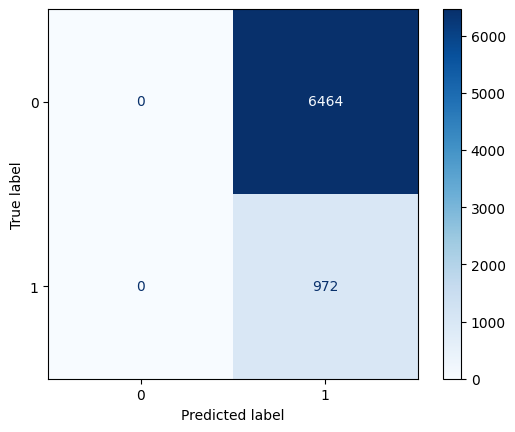



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      6464
           1       0.57      0.37      0.45       972

    accuracy                           0.88      7436
   macro avg       0.74      0.66      0.69      7436
weighted avg       0.87      0.88      0.87      7436



ROC Curve
-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


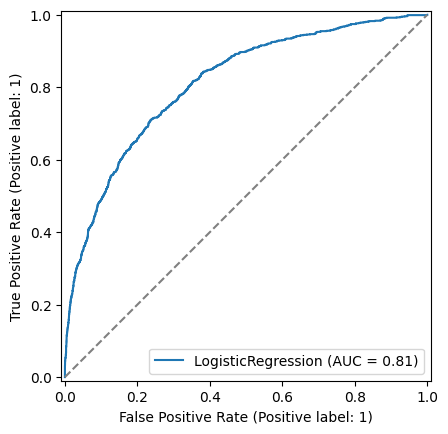



Checking model fitness
-----------------------------------------------------
Train score: 0.5
Test score:  0.1307




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [50]:
 evaluate(logreg_smote, X_train=X_train_resampled, y_train=y_train_resampled, y_pred=y_pred_smote)

#Hyperparameter Tuning

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the base logistic regression model
logreg = LogisticRegression()

# Define the parameter grid for GridSearchCV
logreg_params = {
    'C': [1, 1e8, 1e16],
    'fit_intercept': [True, False],
    'max_iter': [50, 100, 150],
    'random_state': [42]  # Fixed random state
}

# Set up GridSearchCV with 3-fold cross-validation
logreg_gs = GridSearchCV(logreg, logreg_params, scoring='accuracy', cv=3)

# Fit the model on the training data
logreg_gs.fit(X_train, y_train)

# Get the best estimator (model with best parameters)
best_logreg = logreg_gs.best_estimator_




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [54]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [55]:
# Initialize the logistic regression model with a higher max_iter
logreg = LogisticRegression(max_iter=500, random_state=42)

# Define the parameter grid with higher iterations
logreg_params = {
    'C': [1, 1e8, 1e16],
    'fit_intercept': [True, False],
    'max_iter': [300, 500, 700],  # Increased the number of iterations
    'random_state': [42]
}

# GridSearchCV
logreg_gs = GridSearchCV(logreg, logreg_params, scoring='accuracy', cv=3)
logreg_gs.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_logreg = logreg_gs.best_estimator_

# Print best estimator and best parameters
print("Best Estimator:", best_logreg)
print("Best Parameters:", logreg_gs.best_params_)


Best Estimator: LogisticRegression(C=100000000.0, max_iter=300, random_state=42)
Best Parameters: {'C': 100000000.0, 'fit_intercept': True, 'max_iter': 300, 'random_state': 42}


In [56]:
# Make predictions on the scaled test data
y_pred = best_logreg.predict(X_test_scaled)

# Print the predicted values
print("Predicted values:", y_pred)


Predicted values: [0 0 0 ... 0 0 0]


In [65]:


# Check the class distribution in the target variable
print("Class distribution in training data:", np.bincount(y_train))
print("Class distribution in test data:", np.bincount(y_test))


Class distribution in training data: [19293  3012]
Class distribution in test data: [6464  972]


In [66]:

# Step 1: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 2: Initialize the logistic regression model
logreg = LogisticRegression(max_iter=500, random_state=42, solver='liblinear', class_weight='balanced')

# Step 3: Define the parameter grid for GridSearchCV
logreg_params = {
    'C': [0.01, 1, 100],
    'fit_intercept': [True, False],
    'max_iter': [500, 1000, 1500],
    'random_state': [42]
}

# Step 4: Perform Grid Search with 'f1' as the scoring metric (or 'roc_auc' for AUC-ROC)
logreg_gs = GridSearchCV(logreg, logreg_params, scoring='f1', cv=3)
logreg_gs.fit(X_train_resampled, y_train_resampled)

# Step 5: Get the best model and parameters
best_logreg = logreg_gs.best_estimator_

# Step 6: Make predictions on the scaled test data
y_pred = best_logreg.predict(X_test_scaled)

# Step 7: Evaluate the model's performance
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 8: Print the predicted values
print("Predicted values:", y_pred)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.62      0.75      6464
           1       0.25      0.85      0.39       972

    accuracy                           0.65      7436
   macro avg       0.61      0.74      0.57      7436
weighted avg       0.87      0.65      0.71      7436

Predicted values: [1 1 1 ... 0 0 0]


Confusion Matrix
-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


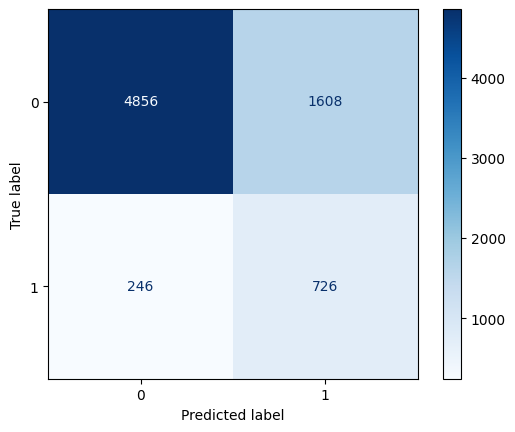



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.62      0.75      6464
           1       0.25      0.85      0.39       972

    accuracy                           0.65      7436
   macro avg       0.61      0.74      0.57      7436
weighted avg       0.87      0.65      0.71      7436



ROC Curve
-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


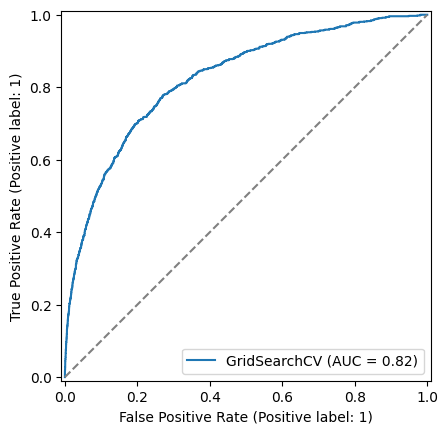



Checking model fitness
-----------------------------------------------------
Train score: 0.4282
Test score:  0.4392




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [67]:
# Make predictions on the scaled test data using the best logistic regression model
y_pred_logreg_gs = best_logreg.predict(X_test_scaled)

# Evaluate the model using the predicted values
evaluate(logreg_gs, y_pred=y_pred_logreg_gs)

#Decision Tree

In [68]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
y_pred_tree

array([0, 0, 1, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


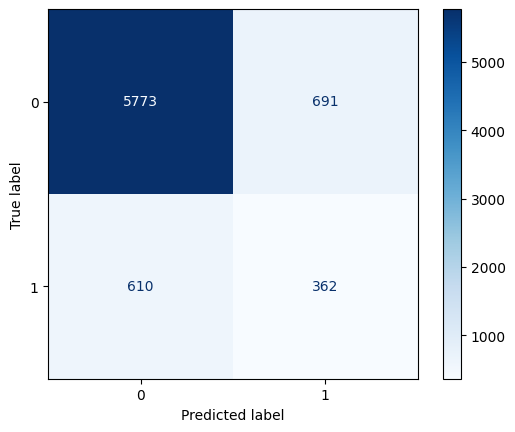



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6464
           1       0.34      0.37      0.36       972

    accuracy                           0.83      7436
   macro avg       0.62      0.63      0.63      7436
weighted avg       0.83      0.83      0.83      7436



ROC Curve
-----------------------------------------------------


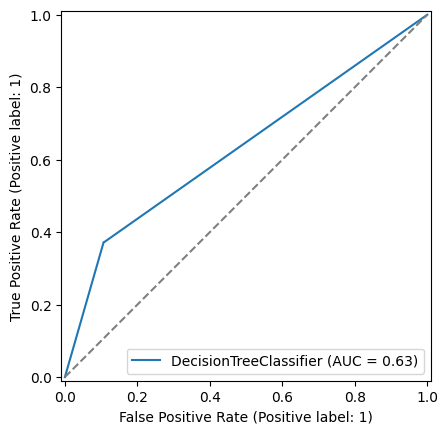



Checking model fitness
-----------------------------------------------------
Train score: 0.9998
Test score:  0.825




In [69]:
evaluate(clf, y_pred=y_pred_tree)

#Hyperparameter Tuning

In [70]:

params = {
 'criterion': ['gini', 'entropy'],
 'max_depth': [3, 7, 11],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 3, 5],
 'random_state': [42]
}
clf_gs = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=3)
clf_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 7, 11], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'random_state': [42]},
             scoring='accuracy')

In [73]:
import os
import joblib

# Create the 'saved_models' directory if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Now you can safely save the model
joblib.dump(clf_gs, 'saved_models/clf_gs.joblib')

['saved_models/clf_gs.joblib']

In [74]:

clf_gs = joblib.load('saved_models/clf_gs.joblib')


In [76]:
import joblib

# Load the model
clf_gs = joblib.load('saved_models/clf_gs.joblib')

# Re-fit the model if necessary (If you have new data or haven't fit it before)
# Assuming X_train and y_train are your training data
# clf_gs.fit(X_train, y_train)

# Access the best parameters
clf_gs.best_params_  # Notice the underscore (_) at the end

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 42}

In [77]:

round(clf_gs.best_score_, 4)


0.8774

In [78]:

y_pred_tree_gs = clf_gs.best_estimator_.predict(X_test)
y_pred_tree_gs


array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


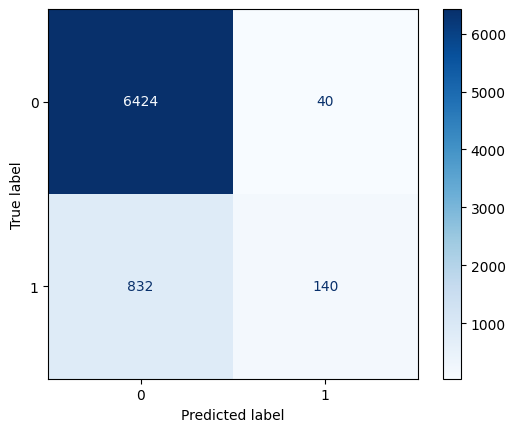



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      6464
           1       0.78      0.14      0.24       972

    accuracy                           0.88      7436
   macro avg       0.83      0.57      0.59      7436
weighted avg       0.87      0.88      0.85      7436



ROC Curve
-----------------------------------------------------


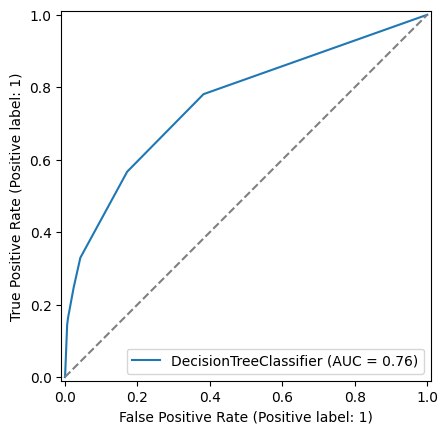



Checking model fitness
-----------------------------------------------------
Train score: 0.8786
Test score:  0.8827




In [79]:

evaluate(clf_gs.best_estimator_, y_pred=y_pred_tree_gs)

#XGBoost

In [82]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
# Step 1: Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 2: Fine-tune the XGBClassifier using GridSearchCV
xgb = XGBClassifier(random_state=42)

# Define parameter grid for XGBClassifier
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, scale_pos_weight]  # Use balanced and original weight
}

# Step 3: Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=3)
grid_search.fit(X_train_resampled, y_train_resampled)

# Step 4: Train the model with the best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_resampled, y_train_resampled)

# Step 5: Make predictions on the test set
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Step 6: Evaluate the model's performance
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Step 7: Print the predicted values
print("Predicted values:", y_pred_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.43      0.60      6464
           1       0.19      0.91      0.32       972

    accuracy                           0.49      7436
   macro avg       0.58      0.67      0.46      7436
weighted avg       0.87      0.49      0.56      7436

Predicted values: [0 1 1 ... 0 0 0]


Confusion Matrix
-----------------------------------------------------


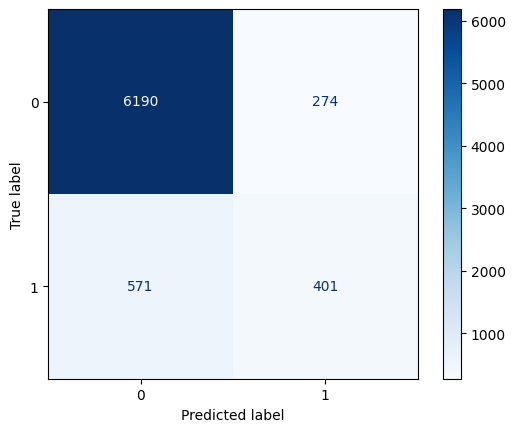



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.43      0.60      6464
           1       0.19      0.91      0.32       972

    accuracy                           0.49      7436
   macro avg       0.58      0.67      0.46      7436
weighted avg       0.87      0.49      0.56      7436



ROC Curve
-----------------------------------------------------


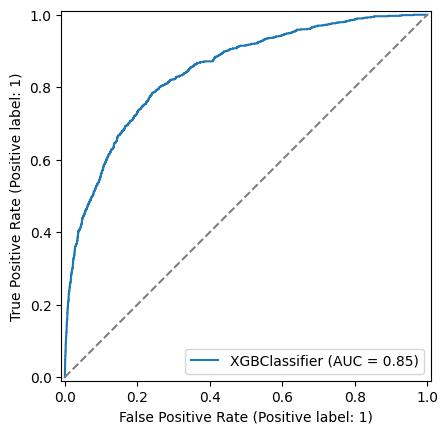



Checking model fitness
-----------------------------------------------------
Train score: 0.9425
Test score:  0.8864




In [84]:
evaluate(best_xgb, y_pred=y_pred_xgb) # Use best_xgb instead of xgb

#Hyperparameter Tuning

In [86]:

xgb_params = {
 'n_estimators': [10, 35, 100],
 'max_depth': [5, 10, 15],
 'learning_rate': [0.01, 0.1, 0.25]
}
xgb_gs = GridSearchCV(xgb, xgb_params, scoring='accuracy', cv=3)
xgb_gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.25],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [10, 35, 100]},
             scoring='accuracy')

In [87]:

joblib.dump(xgb_gs, 'saved_models/xgb_gs.joblib')

['saved_models/xgb_gs.joblib']

In [88]:

xgb_gs = joblib.load('saved_models/xgb_gs.joblib')


In [89]:

xgb_gs.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [90]:

round(xgb_gs.best_score_, 4)


0.8882

In [91]:

y_pred_xgb_gs = xgb_gs.predict(X_test)
y_pred_xgb_gs

array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


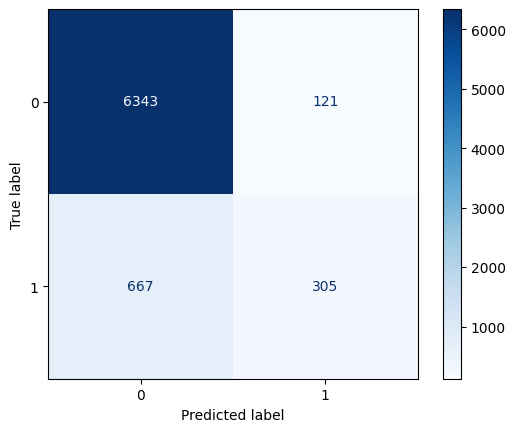



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      6464
           1       0.72      0.31      0.44       972

    accuracy                           0.89      7436
   macro avg       0.81      0.65      0.69      7436
weighted avg       0.88      0.89      0.88      7436



ROC Curve
-----------------------------------------------------


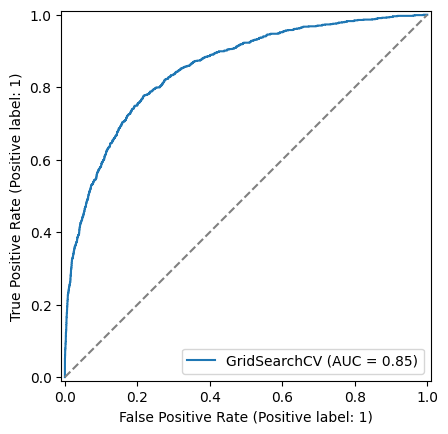



Checking model fitness
-----------------------------------------------------
Train score: 0.9059
Test score:  0.894




In [92]:

evaluate(xgb_gs, y_pred=y_pred_xgb_gs)

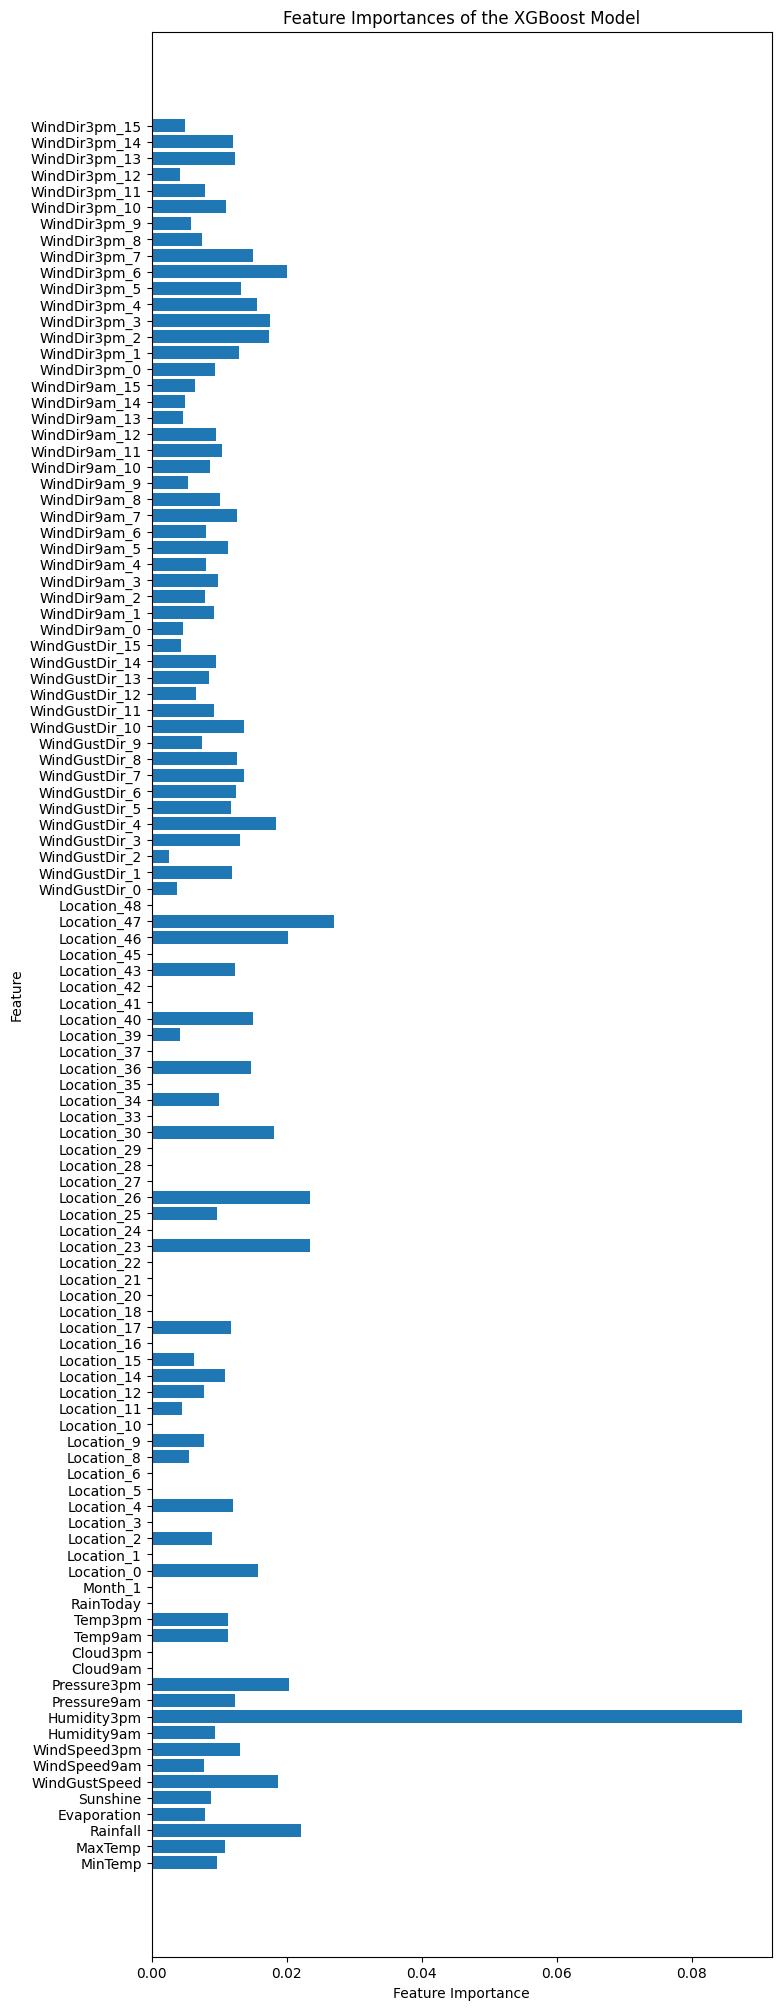

In [94]:


best_xgb = xgb_gs.best_estimator_
plt.figure(figsize=(8, 25))
plt.barh(range(best_xgb.n_features_in_), best_xgb.feature_importances_)
plt.yticks(np.arange(best_xgb.n_features_in_), X_train.columns.values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of the XGBoost Model');

In [95]:

feat_imp_df = pd.DataFrame(data={'Feature': df_final.columns.drop('RainTomorrow'),
 'Importance': best_xgb.feature_importances_
 }
 )
feat_imp_df['Group'] = feat_imp_df.Feature.apply(lambda x: x.split('_')[0])
feat_imp_df


,Feature,Importance,Group
0,MinTemp,0.009621,MinTemp
1,MaxTemp,0.010882,MaxTemp
2,Rainfall,0.022186,Rainfall
3,Evaporation,0.007847,Evaporation
4,Sunshine,0.008819,Sunshine
...,...,...,...
103,WindDir3pm_11,0.007965,WindDir3pm
104,WindDir3pm_12,0.004256,WindDir3pm
105,WindDir3pm_13,0.012426,WindDir3pm
106,WindDir3pm_14,0.012086,WindDir3pm


In [96]:

feat_imp_df.Group.value_counts()

,count
Group,
Location,42
WindDir3pm,16
WindDir9am,16
WindGustDir,16
MaxTemp,1
Month,1
RainToday,1
Temp3pm,1
Temp9am,1


In [97]:

feat_imp_df_grouped = feat_imp_df.groupby(by='Group').sum()
feat_imp_df_grouped.sort_values('Importance', ascending=False, inplace=True)
feat_imp_df_grouped

,Feature,Importance
Group,,
Location,Location_0Location_1Location_2Location_3Locati...,0.269532
WindDir3pm,WindDir3pm_0WindDir3pm_1WindDir3pm_2WindDir3pm...,0.187388
WindGustDir,WindGustDir_0WindGustDir_1WindGustDir_2WindGus...,0.160019
WindDir9am,WindDir9am_0WindDir9am_1WindDir9am_2WindDir9am...,0.131921
Humidity3pm,Humidity3pm,0.087433
Rainfall,Rainfall,0.022186
Pressure3pm,Pressure3pm,0.020330
WindGustSpeed,WindGustSpeed,0.018794
WindSpeed3pm,WindSpeed3pm,0.013045


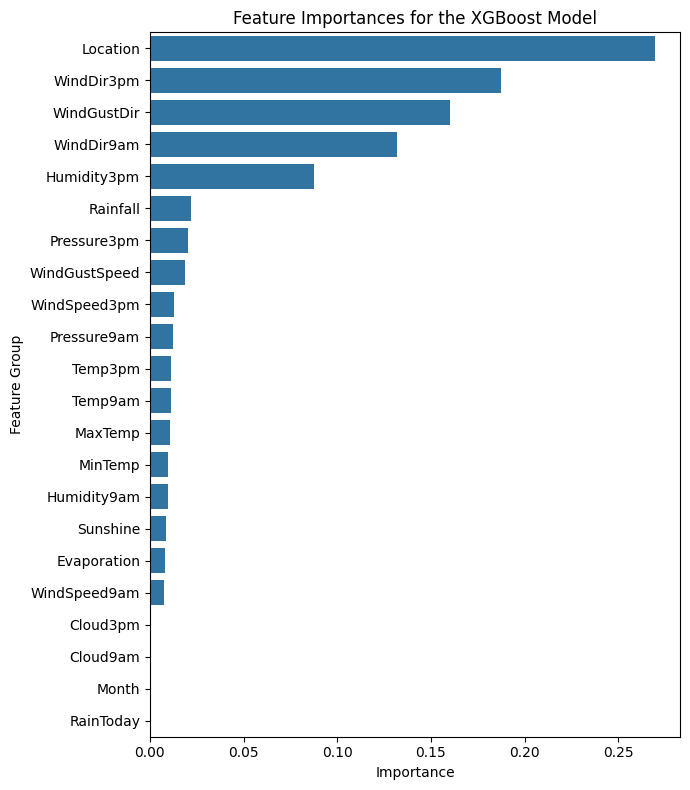

In [99]:

plt.figure(figsize=(7, 8))
sns.barplot(y=feat_imp_df_grouped.index,
 x=feat_imp_df_grouped.Importance,
 orient='h',
 color=sns.color_palette()[0]
 )
plt.title('Feature Importances for the XGBoost Model')
plt.ylabel('Feature Group')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('images/feat_importances.png', facecolor='white', dpi=100);


#Model Comparisons

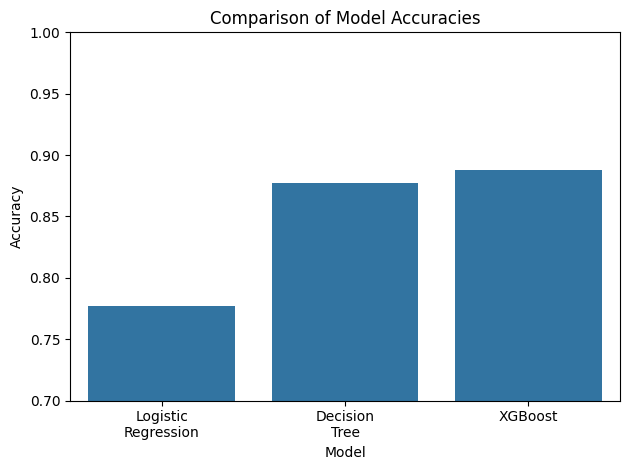

In [102]:
models = [logreg_gs, clf_gs, xgb_gs]
sns.barplot(x=['Logistic\nRegression', 'Decision\nTree',  'XGBoost'],
 y=[model.best_score_ for model in models]
 )
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.title('Comparison of Model Accuracies')
plt.tight_layout()
plt.savefig('images/model_accuracies.png', facecolor='white', dpi=100);

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


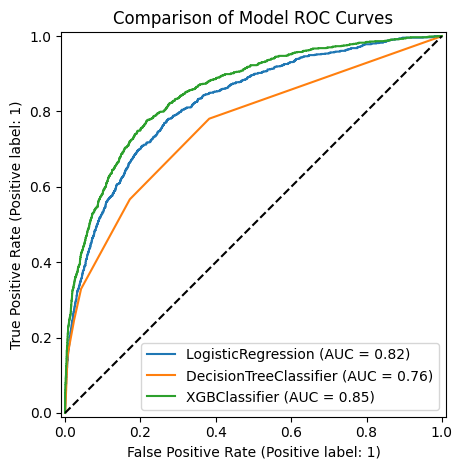

In [104]:
!pip install scikit-learn
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()
for model in models:
 RocCurveDisplay.from_estimator(
 model,
 X_test,
 y_test,
 name=type(model.best_estimator_).__name__,
 ax=ax
 )
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Comparison of Model ROC Curves')
plt.tight_layout()
plt.savefig('images/model_roc_curves.png', facecolor='white', dpi=100);